In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
import pandas as pd

# Load the dataset
file_name = "/kaggle/input/drugpatient-dataset-for-ckd-prediction/CKD_NephrotoxicDrug_Dataset.csv"
df = pd.read_csv(file_name)

# Display the first few rows and information about the DataFrame
print("DataFrame Head:")
print(df.head())
print("\nDataFrame Info:")
df.info()

DataFrame Head:
   patient_age  gender  bp_systolic  bp_diastolic  blood_urea  \
0           69    Male        136.5          90.4        45.3   
1           32    Male        125.0          62.6        22.4   
2           89  Female        124.2          71.1        36.0   
3           78    Male         98.7          81.6         4.7   
4           38    Male        147.7          81.4        56.6   

   serum_creatinine  albumin  blood_glucose_random  diabetes  hypertension  \
0              1.42        2                 175.2         0             1   
1              0.66        0                 138.0         0             0   
2              1.72        0                 177.2         0             0   
3              0.34        0                 121.6         0             0   
4              1.39        0                  65.4         0             1   

   ... bioavailability_pct  volume_of_distribution  kidney_cell_viability_pct  \
0  ...               53.69                 

In [3]:
# List of numerical and ordinal/binary columns for correlation analysis
correlation_cols = [
    'ckd_risk_label',  # Target
    'patient_age', 'bp_systolic', 'bp_diastolic', 
    'blood_urea', 'serum_creatinine', 'albumin', 'blood_glucose_random', 
    'diabetes', 'hypertension', 'drug_dosage_mg', 'exposure_days', 
    'nephrotoxic_label', 'mol_weight', 'logP', 'hbond_donors', 
    'hbond_acceptors', 'rotatable_bonds', 'tpsa', 'shape_index_3d', 
    'inertia_x', 'inertia_y', 'inertia_z', 'charge_distribution', 
    'clearance_rate', 'half_life_hr', 'bioavailability_pct', 
    'volume_of_distribution', 'kidney_cell_viability_pct', 
    'mitochondrial_damage', 'oxidative_stress', 'protein_binding_pct', 
    'serum_creatinine_change_pct', 'toxicity_score_composite', 
    'pk_toxic_interaction_score'
]

# Correlation matrix
correlation_matrix = df[correlation_cols].corr(method='pearson')

# Extract correlations with the target variable 'ckd_risk_label'
target_correlation = correlation_matrix['ckd_risk_label'].sort_values(ascending=False)

# Filter for the top 15 most influential features (excluding the target itself)
top_n = 15
top_correlated_features = target_correlation.drop('ckd_risk_label').head(top_n).index.tolist()
top_correlated_features.append('ckd_risk_label') 

print("Top 15 Features Correlated with CKD Risk Label:")
print(target_correlation.drop('ckd_risk_label').head(top_n))



Top 15 Features Correlated with CKD Risk Label:
nephrotoxic_label              0.613738
toxicity_score_composite       0.313251
blood_urea                     0.281110
serum_creatinine               0.268283
serum_creatinine_change_pct    0.214462
diabetes                       0.198411
hypertension                   0.148177
oxidative_stress               0.118031
mitochondrial_damage           0.097982
shape_index_3d                 0.049202
charge_distribution            0.044471
albumin                        0.039877
rotatable_bonds                0.034371
hbond_acceptors                0.023874
clearance_rate                 0.020664
Name: ckd_risk_label, dtype: float64


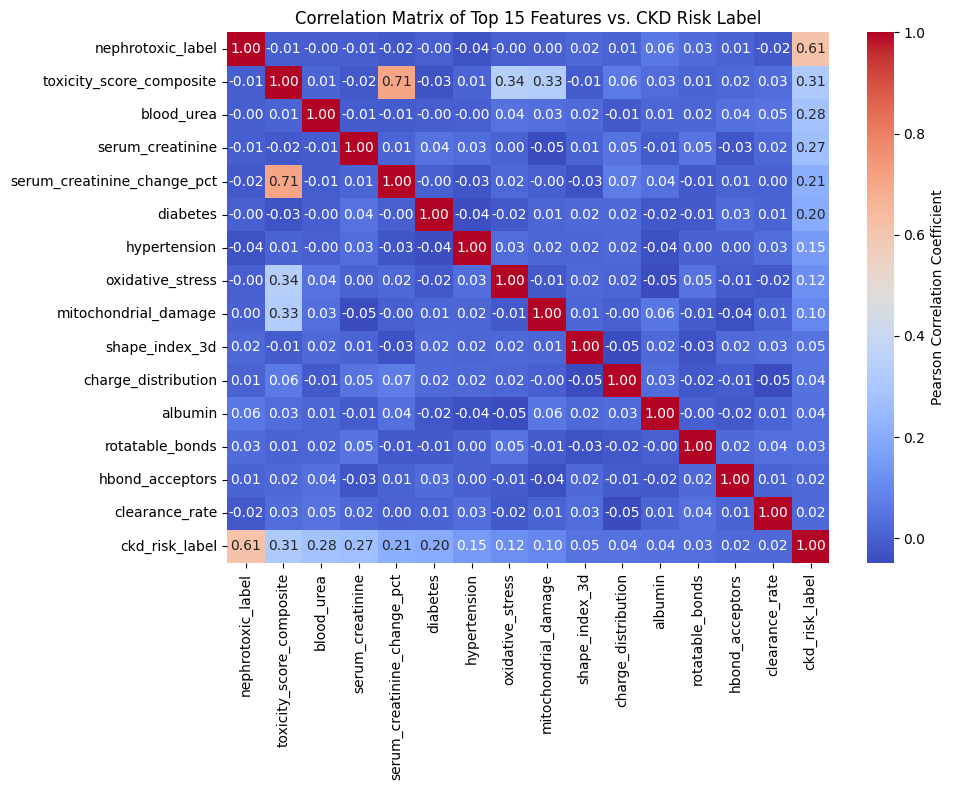

In [4]:
# Correlation matrix for the top features
top_corr_matrix = df[top_correlated_features].corr(method='pearson')

# Plot the heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(top_corr_matrix, annot=True, fmt=".2f", cmap='coolwarm', 
            cbar_kws={'label': 'Pearson Correlation Coefficient'})
plt.title(f'Correlation Matrix of Top {top_n} Features vs. CKD Risk Label')
plt.tight_layout()


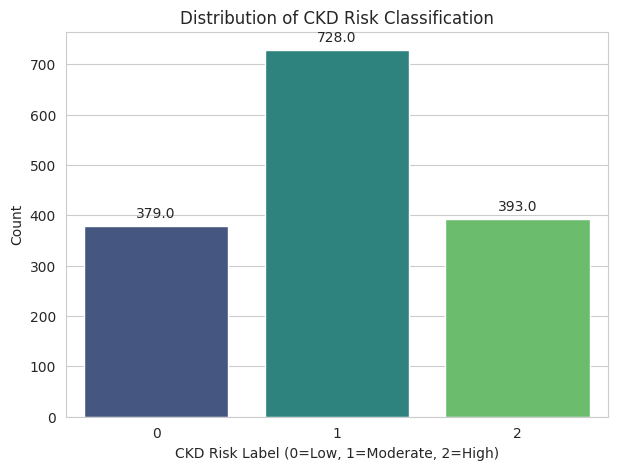

In [5]:
sns.set_style("whitegrid")

plt.figure(figsize=(7, 5))
ax = sns.countplot(x='ckd_risk_label', data=df, palette='viridis')
plt.title('Distribution of CKD Risk Classification')
plt.xlabel('CKD Risk Label (0=Low, 1=Moderate, 2=High)')
plt.ylabel('Count')

# Add counts on top of bars
for p in ax.patches:
    ax.annotate(f'{p.get_height()}', 
                (p.get_x() + p.get_width() / 2., p.get_height()), 
                ha='center', va='center', 
                xytext=(0, 9), 
                textcoords='offset points')

In [6]:
nephrotoxic_risk = df.groupby('ckd_risk_label')['nephrotoxic_label'].value_counts(normalize=True).mul(100).rename('percentage').reset_index()

print("\nNephrotoxic Drug Exposure Percentage by CKD Risk Label:")
print(nephrotoxic_risk)


Nephrotoxic Drug Exposure Percentage by CKD Risk Label:
   ckd_risk_label  nephrotoxic_label  percentage
0               0                  0   88.654354
1               0                  1   11.345646
2               1                  1   69.505495
3               1                  0   30.494505
4               2                  1   94.910941
5               2                  0    5.089059


/usr/local/lib/python3.11/dist-packages/seaborn/axisgrid.py:712: UserWarning: Using the boxplot function without specifying `order` is likely to produce an incorrect plot.
  warnings.warn(warning)
/usr/local/lib/python3.11/dist-packages/seaborn/axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)
/tmp/ipykernel_13/2860792018.py:18: UserWarning: The figure layout has changed to tight
  plt.tight_layout()


<Figure size 1200x500 with 0 Axes>

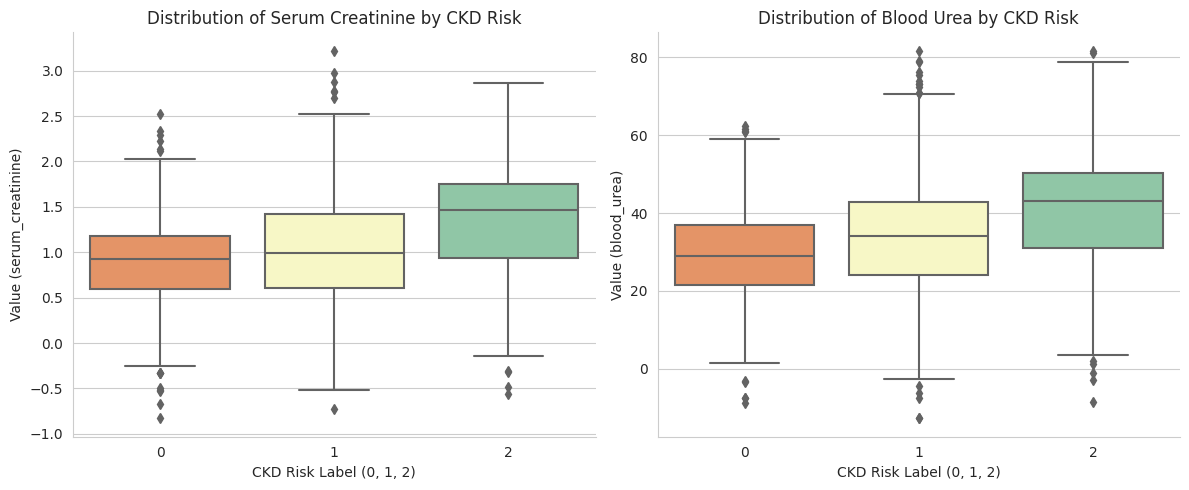

In [7]:
clinical_features = ['serum_creatinine', 'blood_urea']
df_melted = df.melt(id_vars='ckd_risk_label', value_vars=clinical_features, 
                    var_name='Clinical Feature', value_name='Value')

plt.figure(figsize=(12, 5))

# Use FacetGrid to create separate boxplots for each clinical feature
g = sns.FacetGrid(df_melted, col='Clinical Feature', sharey=False, height=5, aspect=1.2)
g.map(sns.boxplot, 'ckd_risk_label', 'Value', palette='Spectral')

# Set titles and labels
for ax in g.axes.flat:
    feature_name = ax.get_title().split('=')[-1].strip()
    ax.set_title(f'Distribution of {feature_name.replace("_", " ").title()} by CKD Risk')
    ax.set_xlabel('CKD Risk Label (0, 1, 2)')
    ax.set_ylabel(f'Value ({feature_name})')

plt.tight_layout()




In [8]:
# Check the drug names associated with high risk (label 2)
high_risk_drugs = df[df['ckd_risk_label'] == 2]['drug_name'].value_counts().head(5)

print("\nTop 5 Drug Names Associated with High CKD Risk (Label 2):")
print(high_risk_drugs)


Top 5 Drug Names Associated with High CKD Risk (Label 2):
drug_name
Cisplatin         86
Tobramycin        78
Gentamicin        76
Vancomycin        74
Amphotericin-B    59
Name: count, dtype: int64
